In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Verifica si tienes una GPU disponible y configura el dispositivo.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo actual:", device)

Dispositivo actual: cuda


In [3]:
# Cargar datos
df = pd.read_pickle('./Datasets/df_ETHUSDT_4h.pickle')
df = df.iloc[59::]
df.reset_index(drop=True, inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume,RSI,EMA20,EMA40,EMA60
0,2020-10-17 09:00:00,368.11,370.46,364.40,367.69,79563.8010,43.151287,371.412062,370.155655,369.361833
1,2020-10-17 13:00:00,367.70,367.98,365.72,366.85,39359.2074,41.928256,370.977580,369.994404,369.279478
2,2020-10-17 17:00:00,366.83,368.84,365.82,368.32,31475.1826,44.872893,370.724477,369.912726,369.248020
3,2020-10-17 21:00:00,368.31,370.00,367.10,368.40,40715.4955,45.036236,370.503098,369.838934,369.220216
4,2020-10-18 01:00:00,368.39,374.39,368.12,373.96,73100.2096,55.013041,370.832327,370.039962,369.375619


In [268]:
# Supongamos que tienes un DataFrame 'df' con las columnas: Open, High, Low, Close, Volume, RSI, EMA20, EMA40, EMA60
# Cargar el DataFrame 'df' con los datos

# Función para preparar los datos
def prepare_data(data, seq_length):
    sequences = []
    target = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length, :]
        label = data[i+seq_length, 3]  # Se asume que la columna 3 es 'Close'
        sequences.append(seq)
        target.append(label)
    return np.array(sequences), np.array(target)

# Parámetros
seq_length = 10  # Longitud de la secuencia
train_size = 0.8  # Porcentaje de datos para entrenamiento

# Preparar los datos
# Supongamos que `df` es tu DataFrame con las columnas mencionadas
# Aquí asumimos que df contiene los datos
data = df[['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'EMA20', 'EMA40', 'EMA60']].values

# Normalizar los datos
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

# Dividir los datos en entrenamiento y evaluación
train_size = int(len(data) * train_size)
train_data = data[:train_size]
eval_data = data[train_size:]

train_sequences, train_target = prepare_data(train_data, seq_length)
eval_sequences, eval_target = prepare_data(eval_data, seq_length)

# Crear tensores para el modelo LSTM
train_sequences = torch.from_numpy(train_sequences).float()
train_target = torch.from_numpy(train_target).float().view(-1, 1)  # Ajustar la forma del tensor
eval_sequences = torch.from_numpy(eval_sequences).float()
eval_target = torch.from_numpy(eval_target).float().view(-1, 1)  # Ajustar la forma del tensor

# Definir el modelo LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Inicializar el modelo, la función de pérdida y el optimizador
model = LSTM(input_size=9, hidden_layer_size=100, output_size=1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento del modelo
epochs = 500
lista_loss = []
for i in range(epochs):
    for seq, labels in zip(train_sequences, train_target):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    lista_loss.append(single_loss.item())
    if i % 1 == 0:  # Cambiado el condicional para mostrar en cada época
        print(f'Epoch {i}, loss: {single_loss.item()}')

# Evaluación del modelo
model.eval()
eval_predictions = []
for seq in eval_sequences:
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        eval_predictions.append(model(seq).item())

# Graficar los resultados
plt.figure(figsize=(24, 12))
plt.plot(eval_target, label='True')
plt.plot(eval_predictions, label='Predicted')
plt.legend()
plt.show()


Epoch 0, loss: 3.208923590136692e-05
Epoch 1, loss: 1.3051149835519027e-05
Epoch 2, loss: 1.3153199688531458e-05
Epoch 3, loss: 1.0609837772790343e-05
Epoch 4, loss: 1.424095535185188e-05
Epoch 5, loss: 7.248864676512312e-06
Epoch 6, loss: 3.980846486228984e-06
Epoch 7, loss: 3.541762453096453e-06
Epoch 8, loss: 5.215114470047411e-06
Epoch 9, loss: 7.243570053105941e-06
Epoch 10, loss: 7.635338988620788e-06
Epoch 11, loss: 1.0341878805775195e-05
Epoch 12, loss: 1.4356579413288273e-05
Epoch 13, loss: 2.089041481667664e-05
Epoch 14, loss: 3.6632611681852723e-06
Epoch 15, loss: 1.1003467079717666e-05
Epoch 16, loss: 1.2839697774325032e-05
Epoch 17, loss: 1.4309191101347096e-05
Epoch 18, loss: 1.166133279184578e-05
Epoch 19, loss: 8.99905262485845e-06
Epoch 20, loss: 7.93937942944467e-06
Epoch 21, loss: 8.135562893585302e-06
Epoch 22, loss: 7.926117177703418e-06
Epoch 23, loss: 9.091193533095066e-06
Epoch 24, loss: 1.0937726074189413e-05
Epoch 25, loss: 1.1633870599325746e-05
Epoch 26, los

KeyboardInterrupt: 

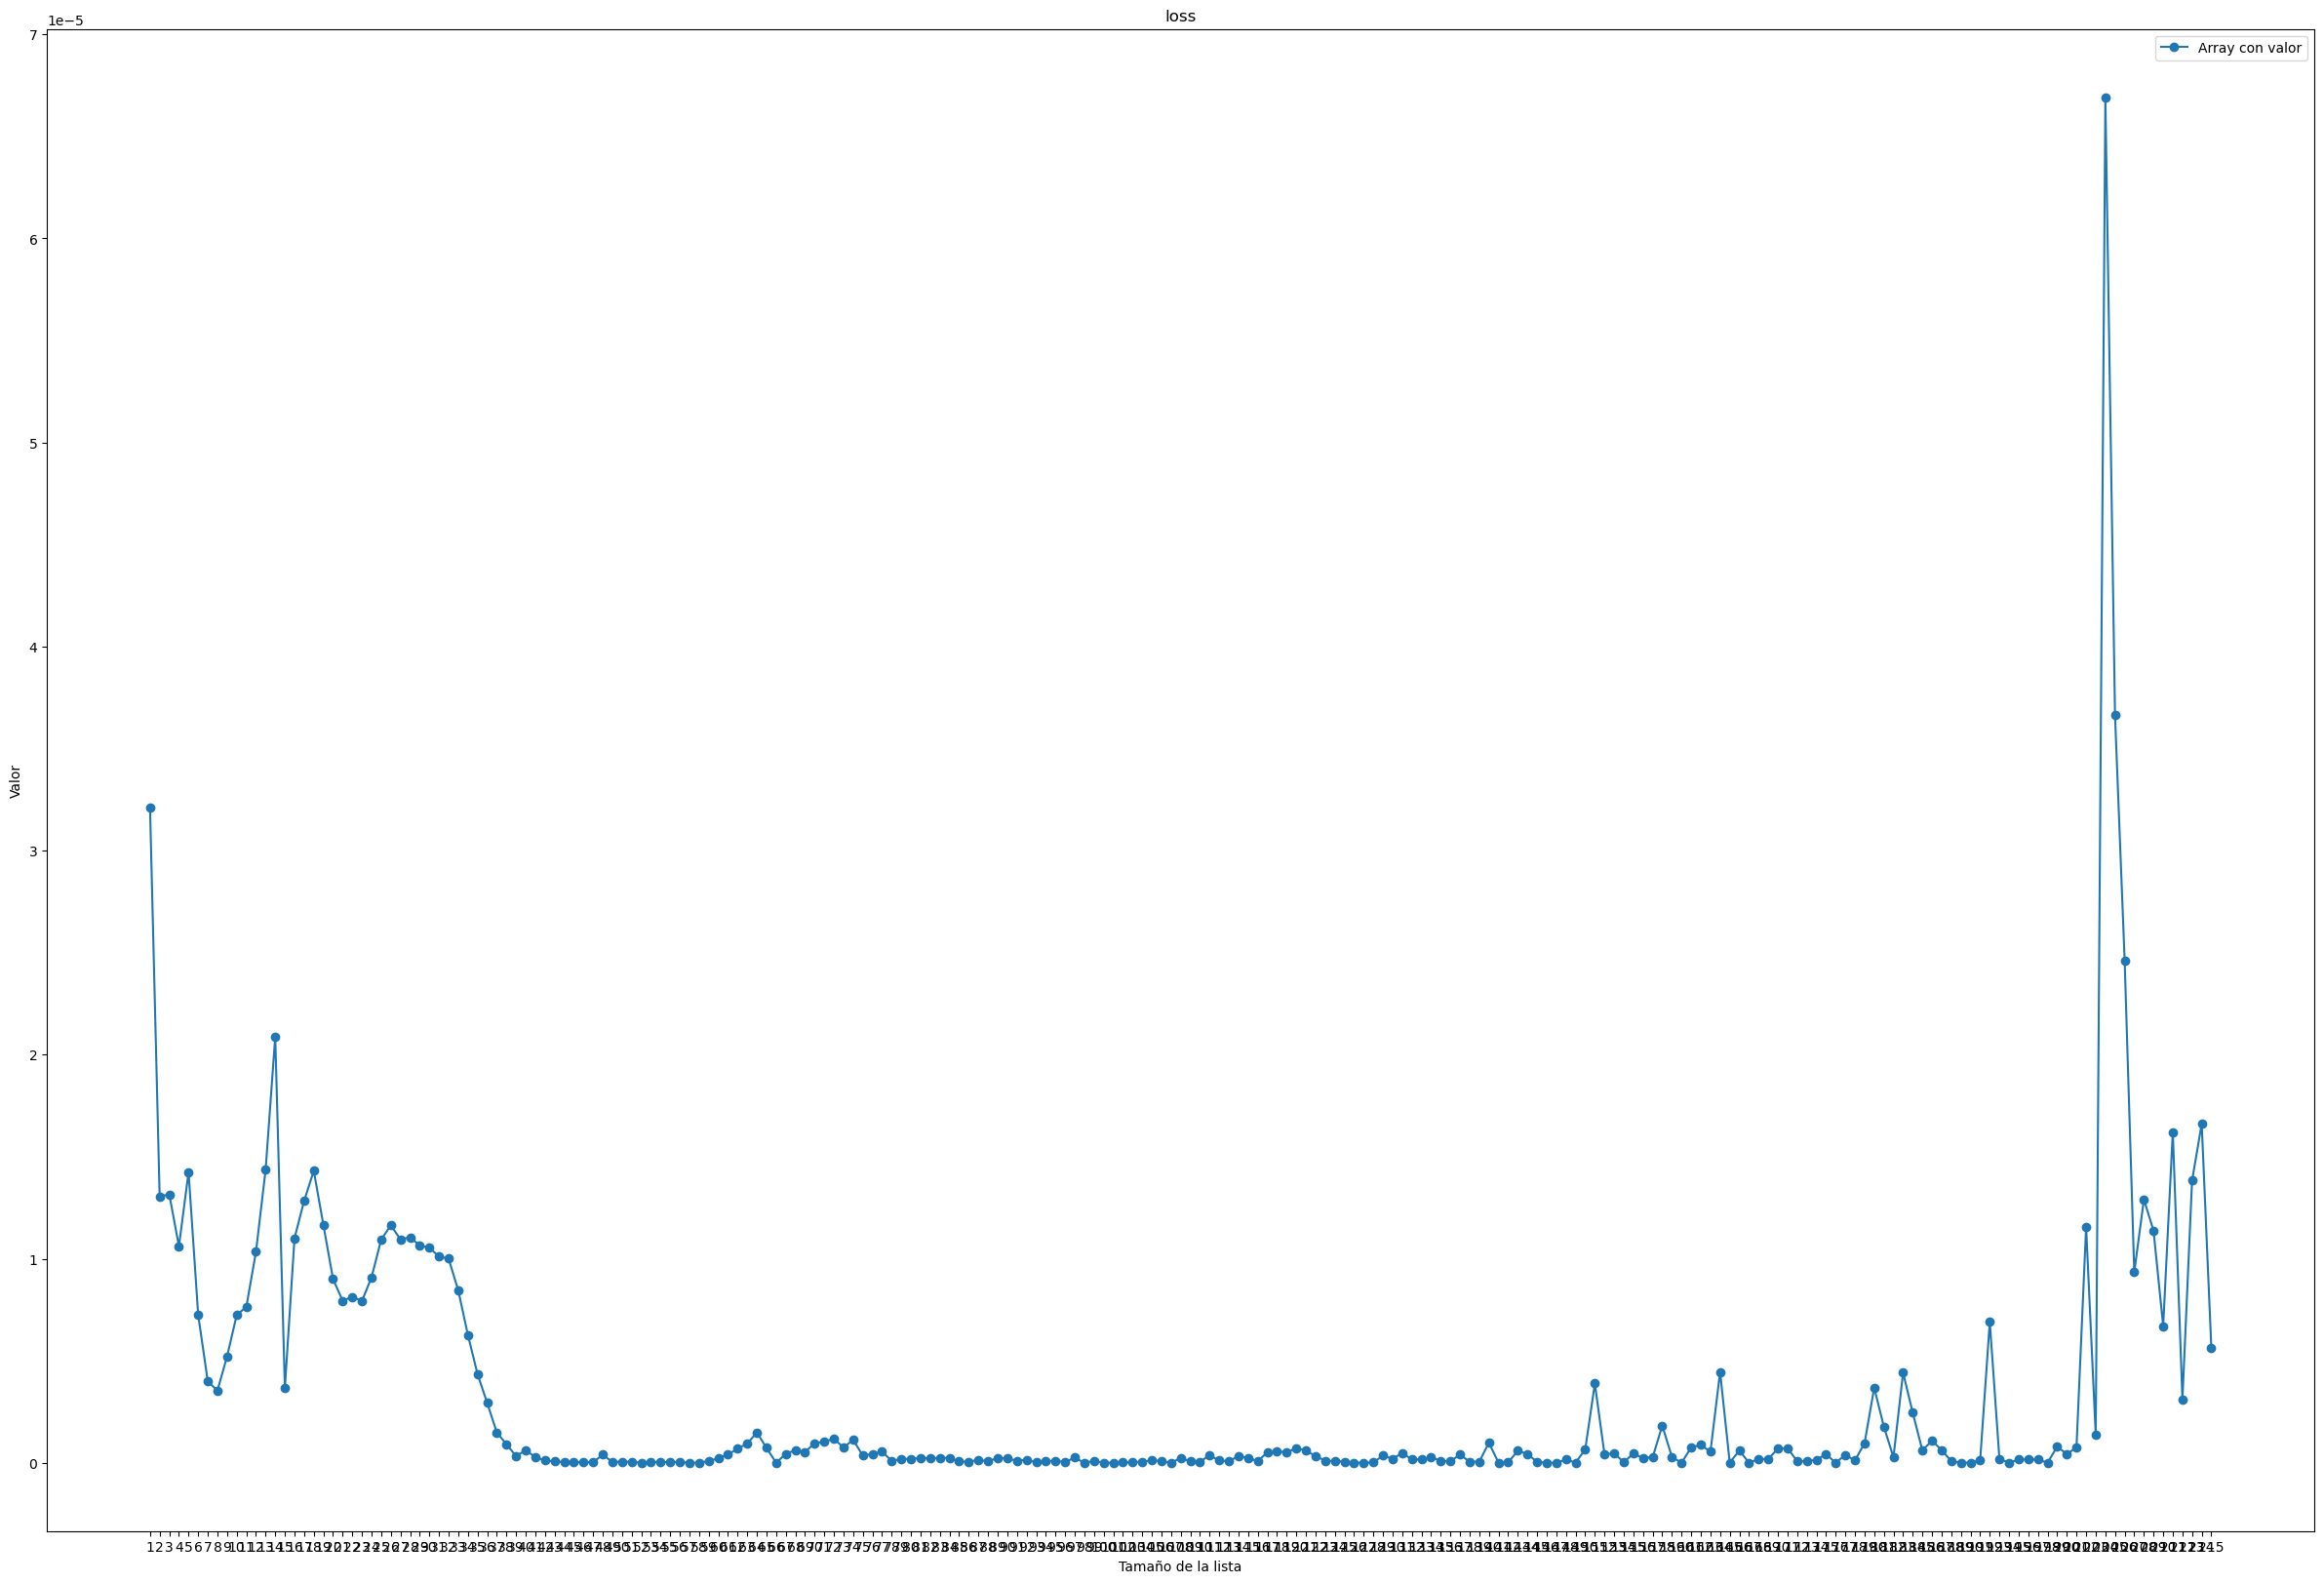

In [269]:
# Crear una lista de índices para representar el tamaño de la lista
indices = list(range(1, len(lista_loss) + 1))

# Establecer el tamaño de la figura
plt.figure(figsize=(30, 20))  # Ancho: 10 pulgadas, Alto: 6 pulgadas

# Trazar el gráfico
plt.plot(indices, lista_loss, 'o-', label='Array con valor')

# Etiquetas y título
plt.xlabel('Tamaño de la lista')
plt.ylabel('Valor')
plt.title('loss')

# Mostrar leyenda
plt.legend()

# Establecer la escala del eje x para que sea de 1 en 1
plt.xticks(indices)

# Mostrar el gráfico
plt.show()

In [ ]:
train_sequences = train_sequences.to(device)
train_target = train_target.to(device)
eval_sequences = eval_sequences.to(device)
eval_target = eval_target.to(device)

model = LSTM(input_size=9, hidden_layer_size=100, output_size=1).to(device)

***

In [5]:
# Supongamos que tienes un DataFrame 'df' con las columnas: Open, High, Low, Close, Volume, RSI, EMA20, EMA40, EMA60
# Cargar el DataFrame 'df' con los datos

# Función para preparar los datos
def prepare_data(data, seq_length):
    sequences = []
    target = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length, :]
        label = data[i+seq_length, 3]  # Se asume que la columna 3 es 'Close'
        sequences.append(seq)
        target.append(label)

    # Convertir las listas a numpy arrays y luego a tensores de PyTorch
    sequences = np.array(sequences)
    target = np.array(target)
    return torch.tensor(sequences, dtype=torch.float32).to(device), torch.tensor(target, dtype=torch.float32).view(-1, 1).to(device)

# Parámetros
seq_length = 10  # Longitud de la secuencia
train_size = 0.8  # Porcentaje de datos para entrenamiento

# Preparar los datos
# Supongamos que `df` es tu DataFrame con las columnas mencionadas
# Aquí asumimos que df contiene los datos
data = df[['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'EMA20', 'EMA40', 'EMA60']].values

# Normalizar los datos
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

# Dividir los datos en entrenamiento y evaluación
train_size = int(len(data) * train_size)
train_data = data[:train_size]
eval_data = data[train_size:]

train_sequences, train_target = prepare_data(train_data, seq_length)
eval_sequences, eval_target = prepare_data(eval_data, seq_length)

# Definir el modelo LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size).to(device),
                            torch.zeros(1,1,self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Inicializar el modelo, la función de pérdida y el optimizador
model = LSTM(input_size=9, hidden_layer_size=100, output_size=1).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento del modelo
epochs = 500
lista_loss = []
for i in range(epochs):
    model.train()  # Establecer el modelo en modo de entrenamiento
    for seq, labels in zip(train_sequences, train_target):
        optimizer.zero_grad()
        model.hidden_cell = (
            torch.zeros(1, 1, model.hidden_layer_size).to(device),
            torch.zeros(1, 1, model.hidden_layer_size).to(device)
        )

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    lista_loss.append(single_loss.item())
    if i % 1 == 0:
        print(f'Epoch {i}, loss: {single_loss.item()}')

# Evaluación del modelo
model.eval()  # Establecer el modelo en modo de evaluación
eval_predictions = []
for seq in eval_sequences:
    with torch.no_grad():
        model.hidden_cell = (
            torch.zeros(1, 1, model.hidden_layer_size).to(device),
            torch.zeros(1, 1, model.hidden_layer_size).to(device)
        )
        eval_predictions.append(model(seq).item())

# Graficar los resultados
plt.figure(figsize=(24, 12))
plt.plot(eval_target.cpu(), label='True')  # Mover los datos a la CPU para graficar
plt.plot(eval_predictions, label='Predicted')
plt.legend()
plt.show()


Epoch 0, loss: 2.340845276194159e-05
Epoch 1, loss: 1.2999306818528567e-05
Epoch 2, loss: 1.3206647963670548e-05
Epoch 3, loss: 1.443256223865319e-05
Epoch 4, loss: 8.48416948429076e-06
Epoch 5, loss: 3.851105248031672e-06
Epoch 6, loss: 3.524732619553106e-06
Epoch 7, loss: 5.9079029597342014e-06


KeyboardInterrupt: 